### CRN compiled using BioCRNpyler

In [1]:
# Import all the required packages here 

from biocrnpyler import *  # To create the model
from bioscrape.types import Model # To simulate the model
from bioscrape.simulator import py_simulate_model # To simulate the model

import pandas as pd
import numpy as np
from matplotlib import style


%config InlineBackend.figure_format = 'retina'

style.use("default")

%matplotlib inline

from GEAGS_data_import import * # To import the experimental data

# Importing the mechanisms and biocrnpyler propensities in this cell 
# I wrote all the mechanism and propensities in a different file 

from BioCRNpyler_Mechanisms import *

from BioCRNpyler_Propensities import *

#### Create Growth Component

In [2]:
# Defining a Cell Growth component 

class CellGrowth(Component):
    """The CellGrowth Component is a component that consists of a cell counter
    and allows for cells to grow.
    """

    def __init__(self, name, attributes=None, material_type=None, **keywords):
        """Initialize a Component object
        :param name: Name of the component (str)
        :param attributes: Species attribute
        :param keywords: pass into the parent's (Component) initializer
        """
        self.species = self.set_species(name, material_type=material_type,
                                        attributes=attributes)
        super().__init__(name=name, **keywords)

    def get_species(self) -> Species:
        return self.species

    def update_species(self) -> List[Species]:
        growth_mech = self.get_mechanism('logistic_cell_growth')
        return growth_mech.update_species()

    def update_reactions(self) -> List:
        growth_mech = self.get_mechanism('logistic_cell_growth')
        return growth_mech.update_reactions(component = self, part_id = self.name)


### Create the 'Mixture' class that contains all the components and the mechanisms, which is then compiled by biocrnpyler

In [3]:
class BacterialMixture(Mixture):
    """A Model for gene expression in growing bacteria. The mixture models resources such as 
    ribosomes, polymerases, endonucleases, nucleotides, and ATP (all labelled as Machinery).

    This model includes cell growth which model the innate loading effects in the cell.
    """
    def __init__(self, name = "bacterialmixture", rnap = "RNAP", sigma = "sigma", ribosome = "Ribo", rnaase = "RNAase", 
                 nucleotide = "NT", aminoacid = "AA", tRNA = "tRNA", unfolded_protein = "unfolded_protein", 
                 Et = "Et", peptide_chain = "peptide_chain", protease = "protease", degtag = True,
                 cell_count = None, **kwargs):
        """Initializes a BacterialMixture instance.

        :param name: name of the mixture, default: bacterialmixture
        :param rnap: name of the RNA polymerase, default: RNAP
        :param sigma: name of the sigma factor, default: sigma
        :param ribosome: name of the ribosome, default: Ribo
        :param rnaase: name of the Ribonuclease, default: RNAase
        :param nucelotide: name of the nucleotide representing species, default: NT
        :param aminoacid: name of the amino acid representing species, default: AA
        :param tRNA: name of the transfer RNA representing species, default: tRNA
        :param Et: name of the tRNA synthetase enzyme
        :param unfolded_protein: name of the unfolded protein representing species, default: unfolded_protein
        :param peptide_chain: name of the species representing all the protein that has been degraded
        :param cell_count: Species representing cell count
        :param degtag: This parameter takes in True or False. True by default. Condition to set deg-tag or not include it
        :param kwargs: keywords passed into the parent Class (Mixture)

        Should pass the argument degtag as True if the protein of interest has a degradation tag on it 
    
        """
        Mixture.__init__(self, name = name, **kwargs)

        # Create Components for TxTl machinery
        self.rnap = Protein(rnap)
        self.sigma = Protein(sigma)
        self.ribosome = Protein(ribosome)
        self.rnaase = Protein(rnaase)
        self.nucleotide = Protein(nucleotide)
        self.aminoacid = Protein(aminoacid)
        self.tRNA = Protein(tRNA)
        self.Et = Protein(Et)
        self.unfolded_protein = Protein(unfolded_protein)
        self.peptide_chain = Protein(peptide_chain)
        self.protease = Protein(protease)
        

        
        self.rnap.add_attribute("machinery")
        self.sigma.add_attribute("machinery")
        self.ribosome.add_attribute("machinery")
        self.rnaase.add_attribute("machinery")
        self.nucleotide.add_attribute("units")
        self.aminoacid.add_attribute("units0tl")
        self.tRNA.add_attribute("machinery")
        self.Et.add_attribute("machinery")
        self.unfolded_protein.add_attribute("degtag")
        self.peptide_chain.add_attribute("peptide")
        self.protease.add_attribute("machinery")
        

        
        self.cell_count = CellGrowth("cell_count")
        self.cell_count.add_attribute("count")
        default_components = [
            self.rnap, self.sigma, self.ribosome, self.rnaase,
            self.nucleotide, self.aminoacid,  
            self.tRNA, self.Et,
            self.unfolded_protein, self.peptide_chain, self.protease,
            self.cell_count
        ]
        self.add_components(default_components)

        self.degtag = degtag

        #Create TxTl Mechansisms
        mech_tx = BacterialTranscription(rnap = self.rnap.get_species(), sigma = self.sigma.get_species(),
                                         nucleotide = self.nucleotide.get_species(),
                                         cell_count = self.cell_count.get_species())
        mech_tl = BacterialTranslation(ribosome = self.ribosome.get_species(), aminoacid = self.aminoacid.get_species(), 
                                       tRNA = self.tRNA.get_species(),
                                       unfolded_protein = self.unfolded_protein.get_species(),
                                       Et = self.Et.get_species(), peptide_chain = self.peptide_chain.get_species(),
                                       protease = self.protease.get_species(),
                                        degtag = self.degtag,
                                       cell_count = self.cell_count.get_species())

        growth_mech = LogisticCellGrowth(cell_count = self.cell_count.get_species())

        # Create Global Dilution and Degradation Mechanisms
        dilution_mechanism = DilutionLogGrowth(cell_count = self.cell_count.get_species(),
                                               filter_dict = {"dna":False, "machinery":False, "count":False, "peptide":True,
                                               "degtag":True, "rna":True, "units":False, "X":True, "units0tl":True},
                                               default_on = False)
        
        mech_rna_deg = BacterialDegradation_mRNA(nuclease = self.rnaase.get_species(),
                                                 nucleotide = self.nucleotide.get_species(),
                                                 cell_count = self.cell_count.get_species(),
                                                 filter_dict = {"rna":True, "machinery":False},
                                                 default_on = False)
        
      
        mech_non_tag_deg = BacterialDegradation_active(unfolded_protein = self.unfolded_protein.get_species(),
                                                      aminoacid = self.aminoacid.get_species(),
                                                      peptide_chain = self.peptide_chain.get_species(),
                                                      cell_count = self.cell_count.get_species(),
                                                      filter_dict = {"X":True, "machinery":False,
                                                                  "dna":False, "degtag":True,"rna":False},
                                                      default_on = False)

        default_mechanisms = {
            mech_tx.mechanism_type: mech_tx,
            mech_tl.mechanism_type: mech_tl,
            growth_mech.mechanism_type:growth_mech,
            mech_rna_deg.mechanism_type:mech_rna_deg,
            mech_non_tag_deg.mechanism_type: mech_non_tag_deg,
            "dilution":dilution_mechanism,
        }

        

        self.add_mechanisms(default_mechanisms)
            

In [4]:
G = DNAassembly("X", promoter = "prom_X", rbs = "rbs_X", transcript = "T_X", protein = "X")

# GEAGS parameters files is already loaded with the correct estimated parameters for the CRN model


M_deg = BacterialMixture("E. coli extract", components = [G],
                     parameter_file = "GEAGS_parameters.txt", overwrite_parameters = False, degtag = True)
CRN_deg = M_deg.compile_crn(add_reaction_species = True)
print(repr(M_deg),"\n", CRN_deg.pretty_print(show_attributes = True, show_material = True, show_rates = True),"\n\n")

M_no_deg = BacterialMixture("E. coli extract", components = [G],
                     parameter_file = "GEAGS_parameters.txt", overwrite_parameters = False, degtag = False)
CRN_no_deg = M_no_deg.compile_crn(add_reaction_species = True)

# Prinitng all the CRN reaction rates 

print(repr(M_no_deg),"\n", CRN_no_deg.pretty_print(show_attributes = True, show_material = True, show_rates = True),"\n\n")

BacterialMixture: E. coli extract
Components = [
	DNAassembly: X
	Protein: RNAP
	Protein: sigma
	Protein: Ribo
	Protein: RNAase
	Protein: NT
	Protein: AA
	Protein: tRNA
	Protein: Et
	Protein: unfolded_protein
	Protein: peptide_chain
	Protein: protease
	CellGrowth: cell_count ]
Mechanisms = {
	transcription:bacterial_transcription
	translation:bacterial_translation
	logistic_cell_growth:logistic_cell_growth }
Global Mechanisms = {
	mrna_degradation:mrna_degradation
	non_tag_degradation:non_tag_degradation
	dilution:global_dilution_logistic_growth } 
 Species(N = 28) = {
protein[unfolded_protein(degtag)] (@ 0),  protein[tRNA(machinery)] (@ 0),  protein[sigma(machinery)] (@ 0),  complex[protein[protease]:protein[unfolded_protein]] (@ 0),  complex[protein[X]:protein[protease]] (@ 0),  complex[protein[RNAase]:rna[T_X]] (@ 0),  complex[protein[RNAP]:protein[sigma]] (@ 0),  complex[protein[AA]:protein[tRNA]] (@ 0),  complex[protein[AA]:protein[Et](amp)] (@ 0),  complex[protein[AA]:protein[Et]

/Users/harikrishnan/.local/lib/python3.8/site-packages/biocrnpyler/global_mechanism.py:104: UserWarning: species complex_complex_protein_AA_units0tl_protein_tRNA_machinery__protein_Ribo_machinery_rna_T_X_ has multiple attributes(or material type) which conflict with global mechanism filter mrna_degradation. Using default value False.
  warn(f"species {repr(s)} has multiple attributes(or material type) which conflict with global mechanism filter {repr(self)}. Using default value {self.default_on}.")
/Users/harikrishnan/.local/lib/python3.8/site-packages/biocrnpyler/global_mechanism.py:104: UserWarning: species dna_X has multiple attributes(or material type) which conflict with global mechanism filter non_tag_degradation. Using default value False.
  warn(f"species {repr(s)} has multiple attributes(or material type) which conflict with global mechanism filter {repr(self)}. Using default value {self.default_on}.")
/Users/harikrishnan/.local/lib/python3.8/site-packages/biocrnpyler/global_m

### Write CRN to an SBML file and then simulate using Bioscrape

In [5]:
CRN_deg.write_sbml_file('GEAGS_biocrnpyler_degtag_070824.xml')

CRN_no_deg.write_sbml_file('GEAGS_biocrnpyler_no_degtag_070824.xml')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/harikrishnan/.local/lib/python3.8/site-packages/biocrnpyler/units.py:134: UserWarning: The string identifier for the unit 1/nM.min is not supported by BioCRNpyler. Add this to the dictionary in biocrnpyler/units.py if you want this unit.
  warnings.warn('The string identifier for the unit {0} is not supported by BioCRNpyler. Add this to the dictionary in biocrnpyler/units.py if you want this unit.'.format(unit_id))
/Users/harikrishnan/.local/lib/python3.8/site-packages/biocrnpyler/units.py:134: UserWarning: The string identifier for the unit 1/min is not supported by BioCRNpyler. Add this to the dictionary in biocrnpyler/units.

True

In [6]:
m_deg = Model(sbml_filename = 'GEAGS_biocrnpyler_degtag_070824.xml')
m_no_deg = Model(sbml_filename = 'GEAGS_biocrnpyler_no_degtag_070824.xml')
t = 1050*1
timepoints = np.linspace(0,t,t*20)

In [7]:
# Deifning the initial conditions for the CRN which were hand fitted 

m_deg.set_species({'dna_X': 100,
 'protein_RNAP_machinery': 200.69,
 'protein_sigma_machinery': 977.63,
 'protein_NT_units': 962.85,
 'protein_Ribo_machinery': 794.8,
 'protein_AA_units0tl': 50000,
 'protein_tRNA_machinery': 580.4,
 'protein_RNAase_machinery': 72,
 'protein_Et_machinery': 563,
 'protein_protease_machinery': 252,
 'protein_unfolded_protein_degtag': 0,
 'rna_T_X':0,
 'protein_X':0,
 'cell_count_count': 6666666.67})

# m_no_deg.set_params({'r_dil__':1,
#               'k_Et__bacterial_translation':0})

m_no_deg.set_species({'dna_X': 100,
 'protein_RNAP_machinery': 200.69,
 'protein_sigma_machinery': 977.63,
 'protein_NT_units': 962.85,
 'protein_Ribo_machinery': 794.8,
 'protein_AA_units0tl': 50000,
 'protein_tRNA_machinery': 580.4,
 'protein_RNAase_machinery': 72,
 'protein_Et_machinery': 563,
 'protein_protease_machinery': 252,
 'protein_unfolded_protein_degtag': 0,
 'rna_T_X':0,
 'protein_X':0,
 'cell_count_count': 6666666.67})

# m_deg.set_params({'r_dil__':1,
#               'k_Et__bacterial_translation':0})

sol_deg = py_simulate_model(timepoints = timepoints, Model = m_deg)
sol_no_deg = py_simulate_model(timepoints = timepoints, Model = m_no_deg)

/Users/harikrishnan/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


## Plotting the results: 

In [8]:
## Importing the experimental data

[C, C_max, C_0, k_gr, C_max_avg, C_0_avg, k_gr_avg] = Get_OD_Data()
[A_non_leaky, time_A, B_non_leaky, time_B, avg_fold_change] = Get_FLOD_Data()

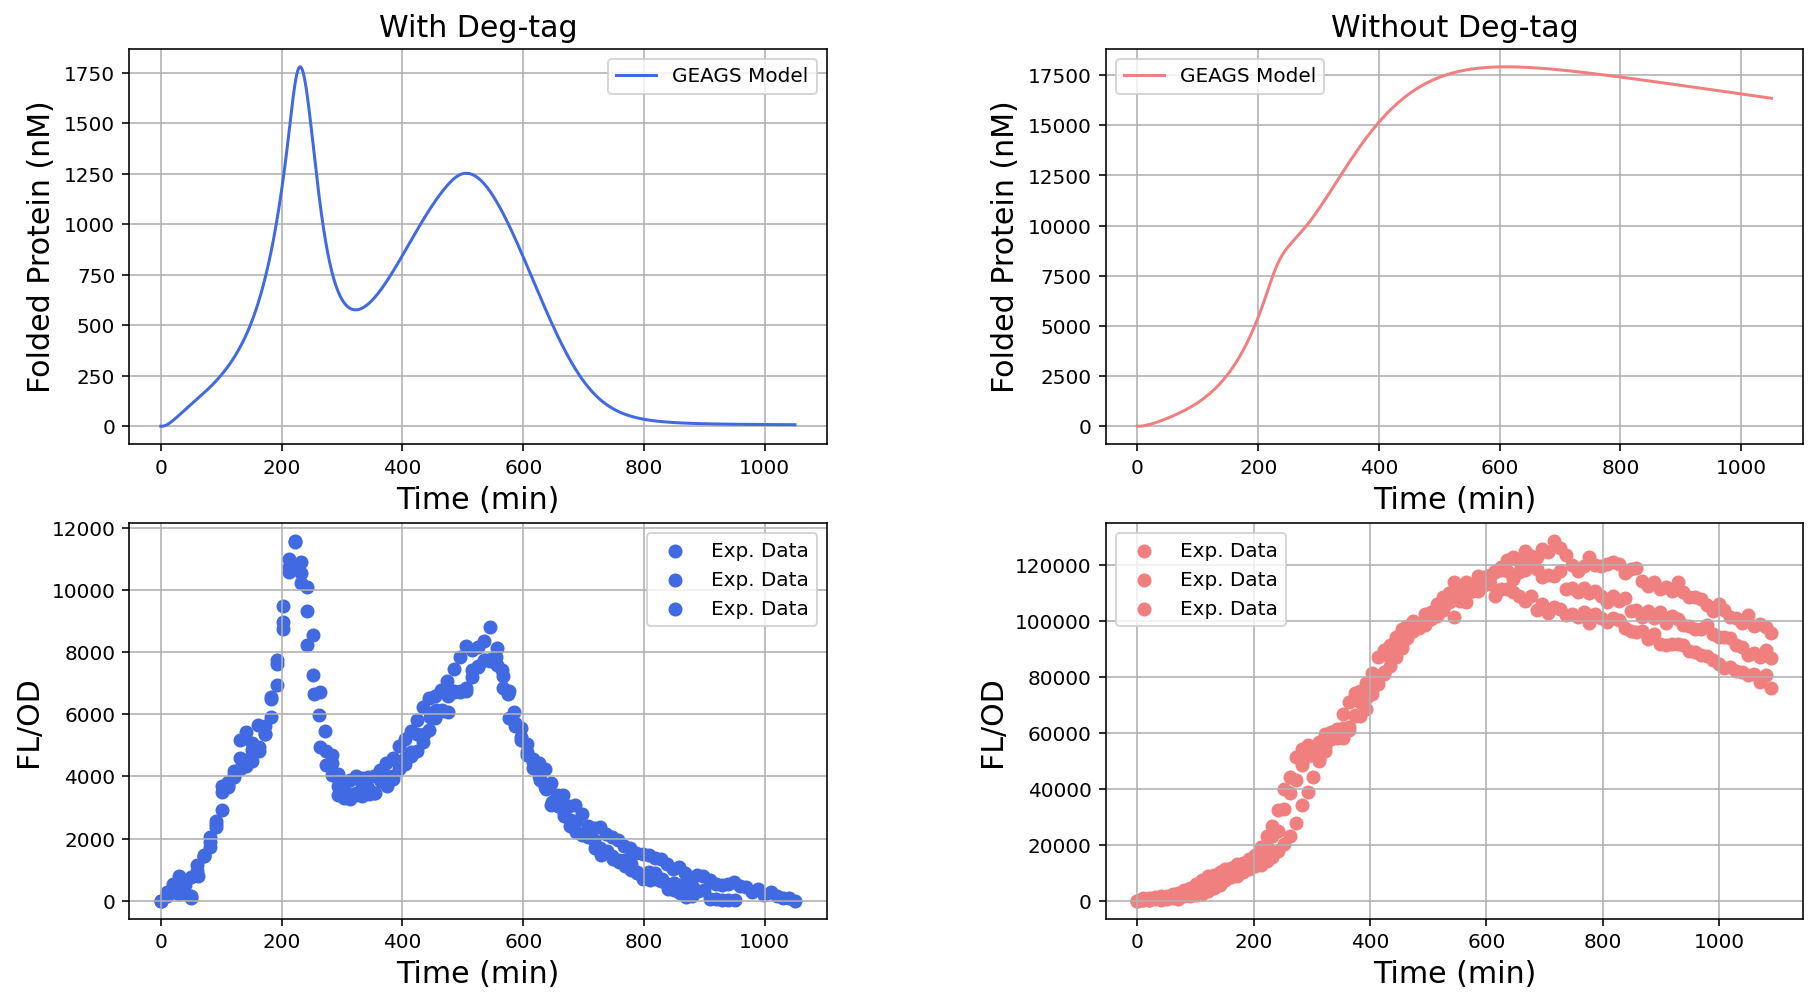

In [9]:
fig, ax = plt.subplots(2,2, figsize = (15,8))
fig.subplots_adjust(wspace = 0.4)#, hspace = 0.1)

r,c = 0,0
ax[r,c].plot(timepoints, sol_deg['protein_X'], label = "GEAGS Model", color = 'royalblue')
ax[r,c].set_xlabel('Time (min)', fontsize = 15) ; ax[r,c].set_ylabel('Folded Protein (nM)', fontsize = 15) 
ax[r,c].set_title('With Deg-tag', fontsize = 15) ; ax[r,c].grid(True) ; ax[r,c].legend()

r,c = 0,1
ax[r,c].plot(timepoints, sol_no_deg['protein_X'], label = "GEAGS Model", color = 'lightcoral')
ax[r,c].set_xlabel('Time (min)', fontsize = 15) ; ax[r,c].set_ylabel('Folded Protein (nM)', fontsize = 15) 
ax[r,c].set_title('Without Deg-tag', fontsize = 15) ; ax[r,c].grid(True) ; ax[r,c].legend()

r,c = 1,0
ax[r,c].scatter(time_A[0], A_non_leaky[0], color = 'royalblue', label = 'Exp. Data')
ax[r,c].scatter(time_A[1], A_non_leaky[1], color = 'royalblue', label = 'Exp. Data')
ax[r,c].scatter(time_A[2], A_non_leaky[2], color = 'royalblue', label = 'Exp. Data')
ax[r,c].set_xlabel('Time (min)', fontsize = 15) ; ax[r,c].set_ylabel('FL/OD', fontsize = 15) ; ax[r,c].legend()
#ax[r,c].set_title('With Deg-tag') ; 
ax[r,c].grid(True)

r,c = 1,1
ax[r,c].scatter(time_B[0], B_non_leaky[0], color = 'lightcoral', label = 'Exp. Data')
ax[r,c].scatter(time_B[1], B_non_leaky[1], color = 'lightcoral', label = 'Exp. Data')
ax[r,c].scatter(time_B[2], B_non_leaky[2], color = 'lightcoral', label = 'Exp. Data')
ax[r,c].set_xlabel('Time (min)', fontsize = 15) ; ax[r,c].set_ylabel('FL/OD', fontsize = 15) ; ax[r,c].legend()
#ax[r,c].set_title('Without Deg-tag') ; 
ax[r,c].grid(True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


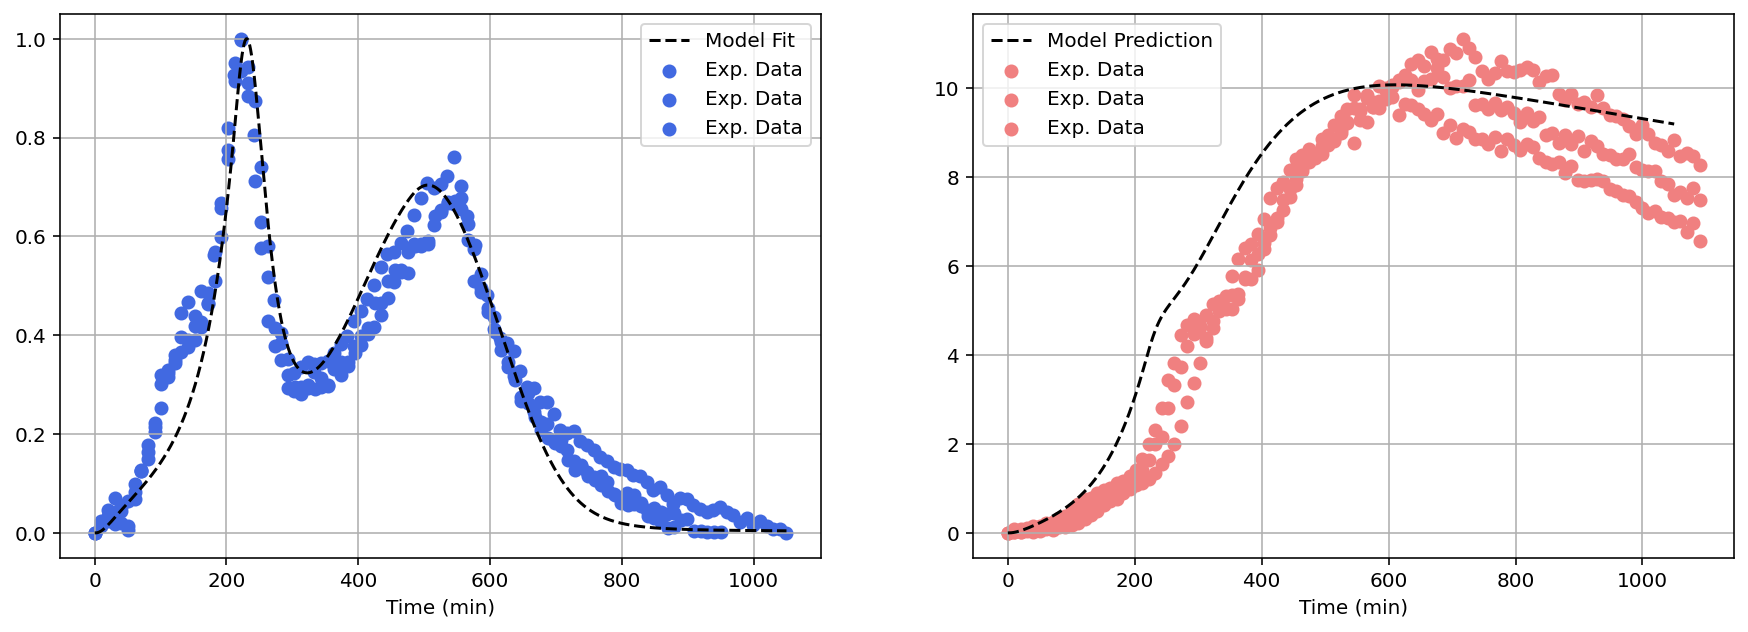

In [10]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
#fig, ax = plt.subplots(2,1, figsize = (8,12))

ax[0].plot(timepoints, sol_deg['protein_X']/np.max(sol_deg['protein_X']), '--', label = "Model Fit", color = 'black')
ax[0].scatter(time_A[0], A_non_leaky[0]/np.max(A_non_leaky[2]), color = 'royalblue', label = 'Exp. Data')
ax[0].scatter(time_A[1], A_non_leaky[1]/np.max(A_non_leaky[2]), color = 'royalblue', label = 'Exp. Data')
ax[0].scatter(time_A[2], A_non_leaky[2]/np.max(A_non_leaky[2]), color = 'royalblue', label = 'Exp. Data')
ax[0].set_xlabel('Time (min)'); ax[0].grid(True) ; ax[0].legend()

ax[1].plot(timepoints, sol_no_deg['protein_X']/np.max(sol_deg['protein_X']), '--', label = "Model Prediction", color = 'black')
ax[1].scatter(time_B[0], B_non_leaky[0]/np.max(A_non_leaky[2]), color = 'lightcoral', label = 'Exp. Data')
ax[1].scatter(time_B[1], B_non_leaky[1]/np.max(A_non_leaky[2]), color = 'lightcoral', label = 'Exp. Data')
ax[1].scatter(time_B[2], B_non_leaky[2]/np.max(A_non_leaky[2]), color = 'lightcoral', label = 'Exp. Data')
ax[1].set_xlabel('Time (min)'); ax[1].grid(True) ; ax[1].legend()

#fig.savefig("GEAGS_qualitative_comparison.png")

### With deg tag

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


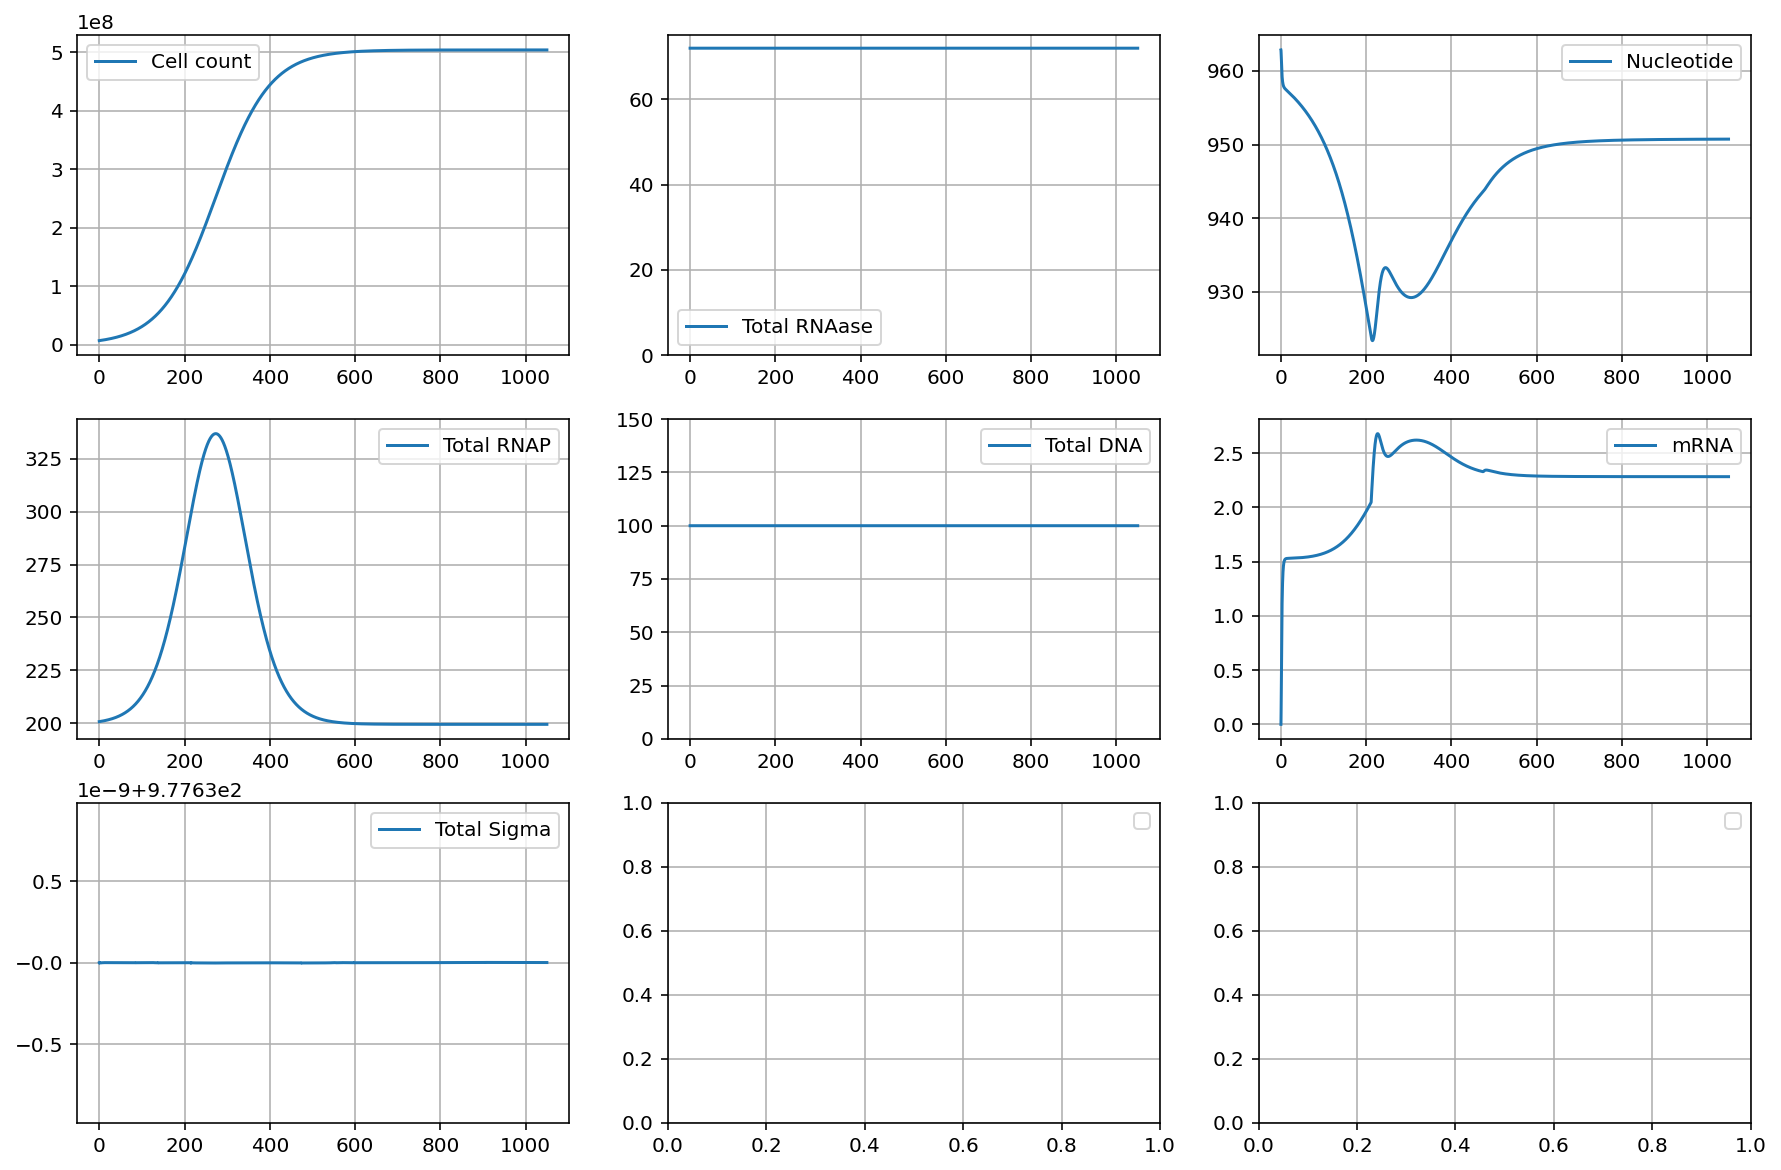

In [11]:
# Total rnap, bound and unbound
RNAP_total = np.zeros(len(timepoints))
RNAP_total[:] = sol_deg['protein_RNAP_machinery'][:] + sol_deg['complex_protein_RNAP_machinery_protein_sigma_machinery_'][:]  
RNAP_total[:] += sol_deg['complex_complex_protein_RNAP_machinery_protein_sigma_machinery__dna_X_open_'][:] 



# Total DNA, bound and unbound
DNA_total = np.zeros(len(timepoints))
DNA_total[:] = sol_deg['dna_X'][:] + sol_deg['complex_complex_protein_RNAP_machinery_protein_sigma_machinery__dna_X_open_'][:]

# Total sigma, bound and unbound
sigma_total = np.zeros(len(timepoints))
sigma_total[:] = sol_deg['protein_sigma_machinery'][:] + sol_deg['complex_protein_RNAP_machinery_protein_sigma_machinery_'][:] 
sigma_total[:] += sol_deg['complex_complex_protein_RNAP_machinery_protein_sigma_machinery__dna_X_open_'][:] 

# Total RNAase, bound and unbound
rnaase_total = np.zeros(len(timepoints))
rnaase_total[:] = sol_deg['protein_RNAase_machinery'][:] + sol_deg['complex_protein_RNAase_machinery_rna_T_X_'][:]

fig,ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))
ax[0][0].plot(timepoints, sol_deg['cell_count_count'], label = "Cell count")
ax[0][1].plot(timepoints, rnaase_total, label = "Total RNAase");ax[0][1].set_ylim(bottom = 0, top = 75)
ax[0][2].plot(timepoints, sol_deg['protein_NT_units'], label = "Nucleotide")
ax[1][0].plot(timepoints, RNAP_total, label = "Total RNAP")
ax[1][1].plot(timepoints, DNA_total, label = "Total DNA");ax[1][1].set_ylim(bottom = 0, top = 150)
ax[1][2].plot(timepoints, sol_deg['rna_T_X'], label = "mRNA")
ax[2][0].plot(timepoints, sigma_total, label = "Total Sigma"); #ax[2][0].set_ylim(bottom = 0, top = 1500)


ax[0][0].legend() ; ax[0][0].grid(); 
ax[0][1].legend() ; ax[0][1].grid(); 
ax[0][2].legend() ; ax[0][2].grid(); 
ax[2][0].legend() ; ax[1][0].grid(); 
ax[1][0].legend() ; ax[1][1].grid(); 
ax[1][1].legend() ; ax[1][2].grid(); 
ax[1][2].legend() ; ax[2][0].grid(); 
ax[2][1].legend() ; ax[2][1].grid(); 
ax[2][2].legend() ; ax[2][2].grid(); 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


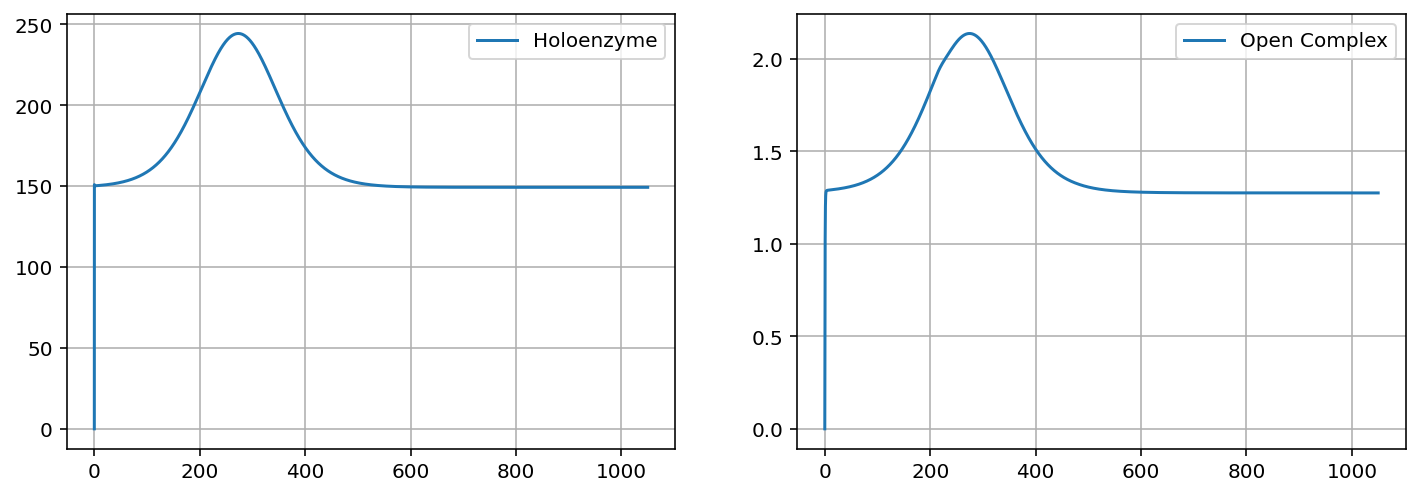

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax[0].plot(timepoints, sol_deg['complex_protein_RNAP_machinery_protein_sigma_machinery_'], label = 'Holoenzyme')
ax[1].plot(timepoints, sol_deg['complex_complex_protein_RNAP_machinery_protein_sigma_machinery__dna_X_open_'] , label = 'Open Complex')
ax[0].legend(); ax[1].legend(); 
ax[0].grid(); ax[1].grid(); 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


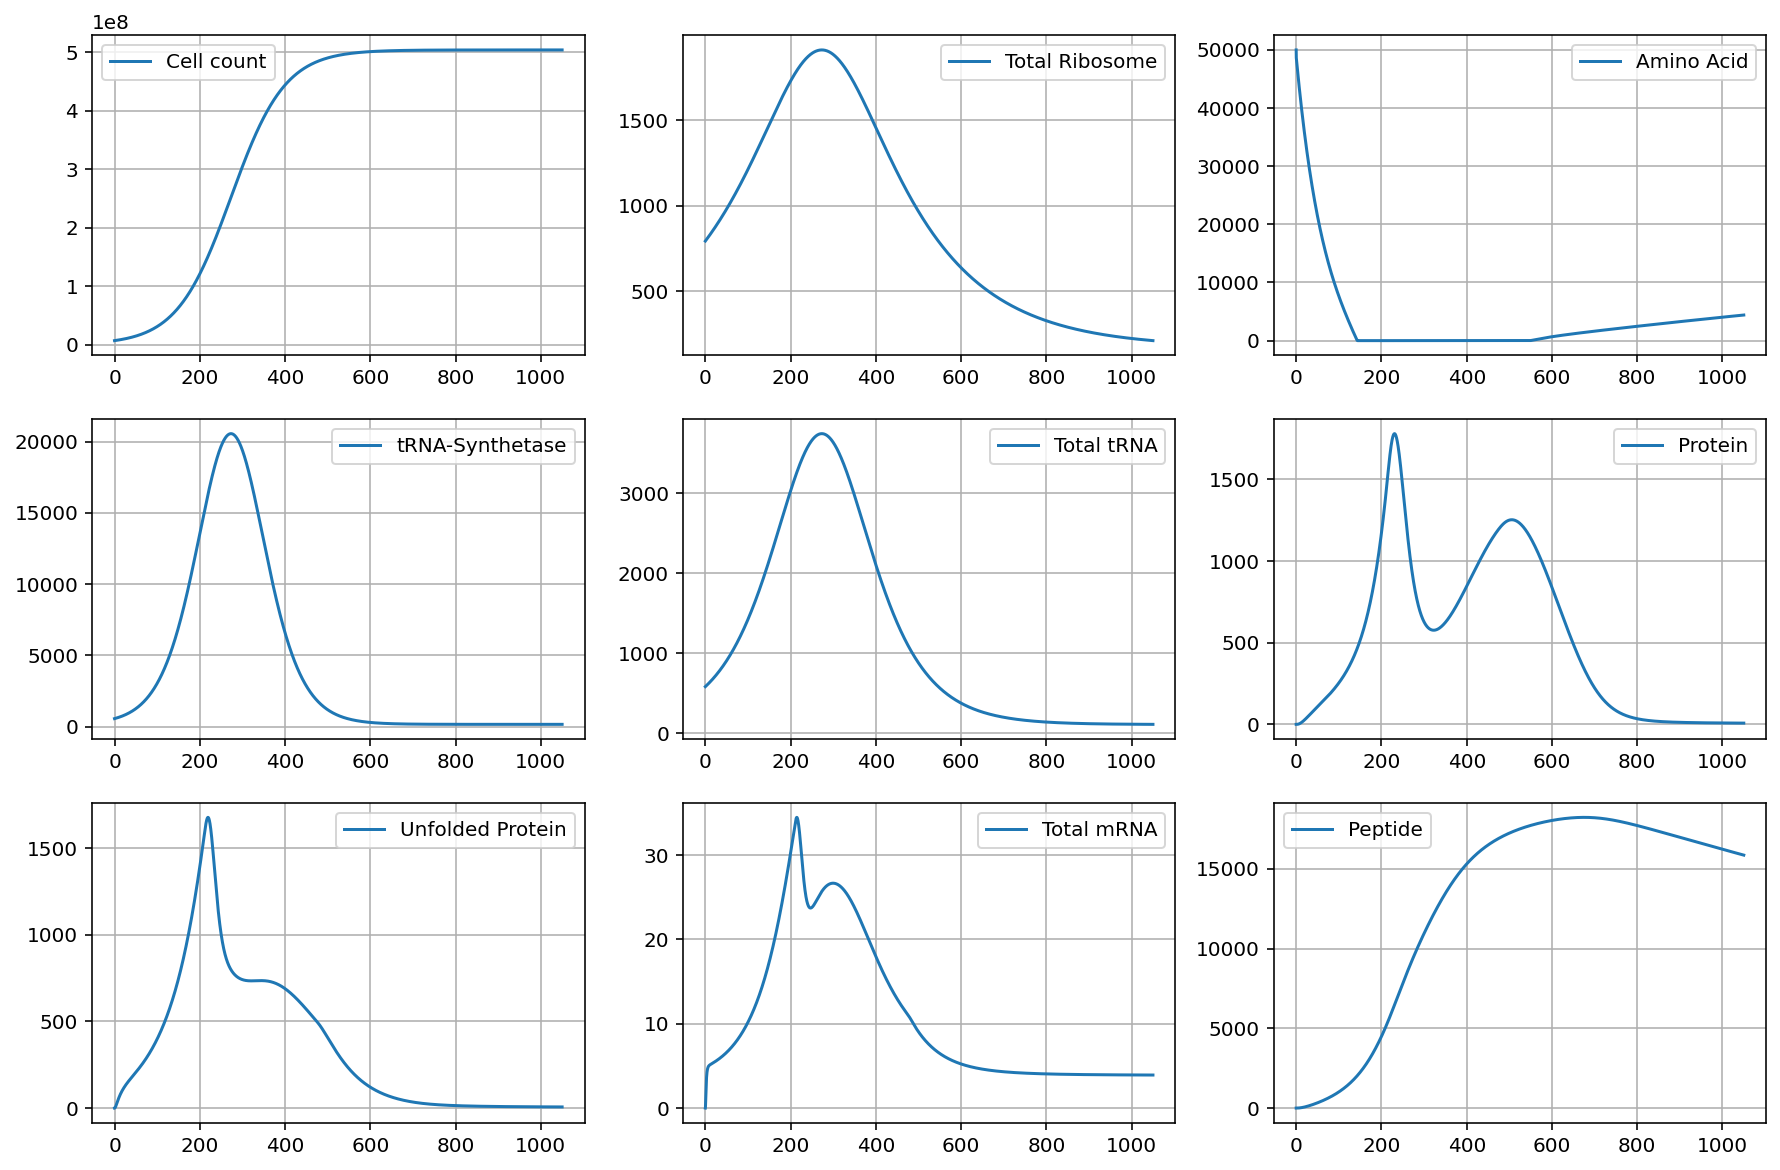

In [13]:
# Total Ribosome, bound and unbound
ribo_total = np.zeros(len(timepoints))
ribo_total[:] = sol_deg['protein_Ribo_machinery'][:]
ribo_total[:] += sol_deg['complex_complex_protein_AA_units0tl_protein_tRNA_machinery__protein_Ribo_machinery_rna_T_X_'][:]

# Total tRNA, bound and unbound
tRNA_total = np.zeros(len(timepoints))
tRNA_total[:] = sol_deg['protein_tRNA_machinery'][:] + sol_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_inactive_'][:]
tRNA_total[:] += sol_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_active_'][:]
tRNA_total[:] += sol_deg['complex_protein_AA_units0tl_protein_tRNA_machinery_'][:]
tRNA_total[:] += sol_deg['complex_complex_protein_AA_units0tl_protein_tRNA_machinery__protein_Ribo_machinery_rna_T_X_'][:]

# Total mRNA, bound and unbound
mrna_total = np.zeros(len(timepoints))
mrna_total[:] = sol_deg['rna_T_X'][:]
mrna_total[:] += sol_deg['complex_complex_protein_AA_units0tl_protein_tRNA_machinery__protein_Ribo_machinery_rna_T_X_'][:]
mrna_total[:] += sol_deg['complex_protein_RNAase_machinery_rna_T_X_'][:]


# Total tRNA synthetase
synth_total = np.zeros(len(timepoints))
synth_total[:] = sol_deg['protein_Et_machinery'][:]
synth_total[:] += sol_deg['complex_protein_AA_units0tl_protein_Et_machinery_'][:]
synth_total[:] += sol_deg['complex_protein_AA_units0tl_protein_Et_machinery_amp_'][:]
synth_total[:] += sol_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_inactive_'][:]
synth_total[:] += sol_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_active_'][:]


# Total Amino Acid 
aa_total = np.zeros(len(timepoints))
aa_total[:] = sol_deg['protein_AA_units0tl'][:]
aa_total[:] += sol_deg['complex_protein_AA_units0tl_protein_Et_machinery_'][:]
aa_total[:] += sol_deg['complex_protein_AA_units0tl_protein_Et_machinery_amp_'][:]
aa_total[:] += sol_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_inactive_'][:]
aa_total[:] += sol_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_active_'][:]
aa_total[:] += sol_deg['complex_protein_AA_units0tl_protein_tRNA_machinery_'][:]
aa_total[:] += sol_deg['complex_complex_protein_AA_units0tl_protein_tRNA_machinery__protein_Ribo_machinery_rna_T_X_'][:]

fig,ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))
# ax.set_title("Growth dependent gene expression")

ax[0][0].plot(timepoints, sol_deg['cell_count_count'], label = "Cell count")
ax[0][1].plot(timepoints, ribo_total, label = "Total Ribosome")
ax[0][2].plot(timepoints, sol_deg['protein_AA_units0tl'] , label = "Amino Acid")
ax[1][0].plot(timepoints, synth_total, label = "tRNA-Synthetase")
ax[1][1].plot(timepoints, tRNA_total, label = "Total tRNA")
ax[1][2].plot(timepoints, sol_deg['protein_X'], label = "Protein")
ax[2][0].plot(timepoints, sol_deg['protein_unfolded_protein_degtag'], label = "Unfolded Protein")
ax[2][1].plot(timepoints, mrna_total, label = "Total mRNA")
ax[2][2].plot(timepoints, sol_deg['protein_peptide_chain_peptide'], label = "Peptide")


ax[0][0].legend() ; ax[0][0].grid(); 
ax[0][1].legend() ; ax[0][1].grid(); 
ax[0][2].legend() ; ax[0][2].grid(); 
ax[2][0].legend() ; ax[1][0].grid(); 
ax[1][0].legend() ; ax[1][1].grid(); 
ax[1][1].legend() ; ax[1][2].grid(); 
ax[1][2].legend() ; ax[2][0].grid(); 
ax[2][1].legend() ; ax[2][1].grid(); 
ax[2][2].legend() ; ax[2][2].grid(); 


In [14]:
sol_deg.columns

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['dna_X', 'protein_RNAP_machinery', 'protein_sigma_machinery',
       'protein_NT_units', 'rna_T_X',
       'complex_protein_RNAP_machinery_protein_sigma_machinery_',
       'complex_complex_protein_RNAP_machinery_protein_sigma_machinery__dna_X_',
       'protein_Ribo_machinery', 'protein_AA_units0tl',
       'protein_tRNA_machinery', 'protein_X',
       'protein_unfolded_protein_degtag', 'protein_Et_machinery',
       'protein_peptide_chain_peptide', 'protein_protease_machinery',
       'complex_protein_AA_units0tl_protein_Et_machinery_',
       'complex_complex_protein_AA_units0tl_protein_Et_machinery__protein_tRNA_machinery_',
       'complex_protein_AA_units0tl_protein_tRNA_machinery_',
       'complex_complex_protein_AA_units0tl_protein_tRNA_machinery__protein_Ribo_machinery_rna_T_X_',
       'complex_protein_protease_machinery_protein_unfolded_protein_degtag_',
       'complex_protein_X_protein_protease_machinery_',
       'protein_RNAase_machinery', 'cell_count_count',
   

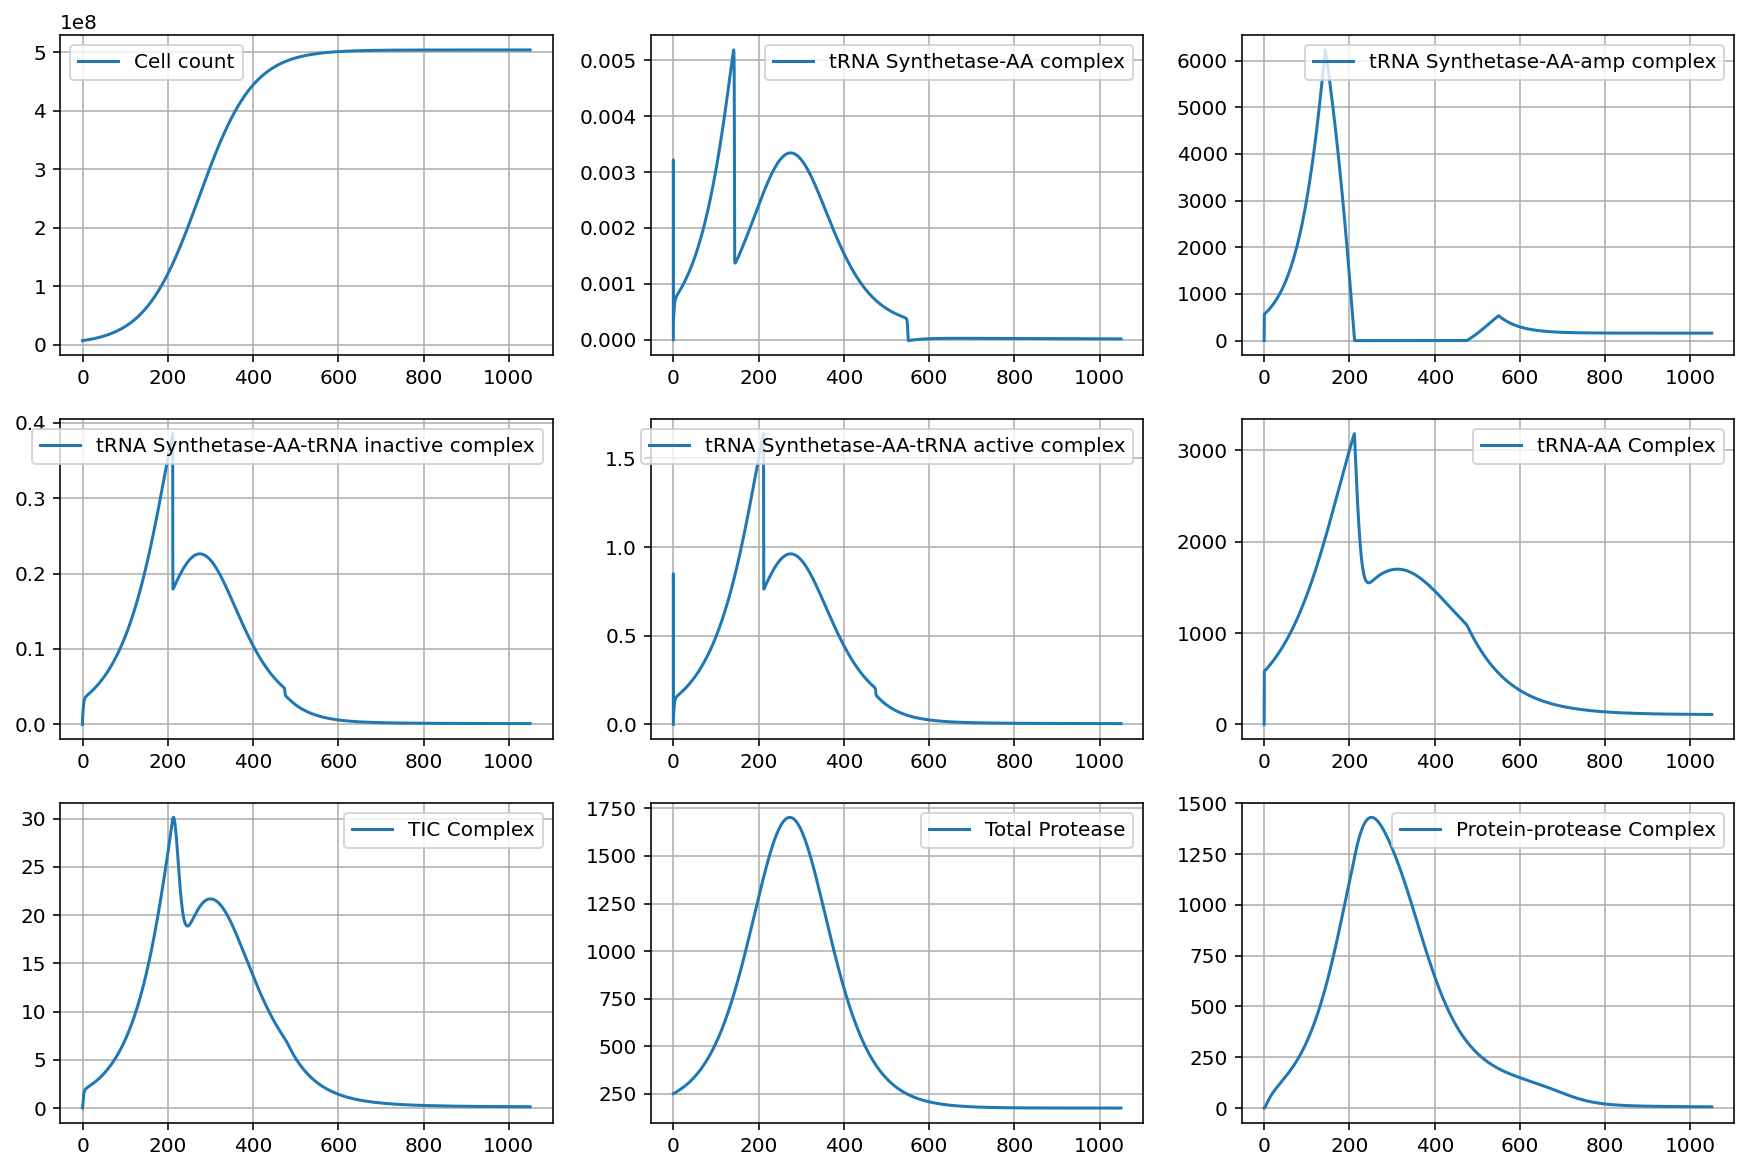

In [15]:
fig,ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))
# ax.set_title("Growth dependent gene expression")

protease_total = np.zeros(len(timepoints))
protease_total[:] = sol_deg['protein_protease_machinery'][:]
protease_total[:] += sol_deg['complex_protein_protease_machinery_protein_unfolded_protein_degtag_'][:]
protease_total[:] += sol_deg['complex_protein_X_protein_protease_machinery_'][:]

deg_complex = np.zeros(len(timepoints))
deg_complex[:] = sol_deg['complex_protein_protease_machinery_protein_unfolded_protein_degtag_'][:]
deg_complex[:] += sol_deg['complex_protein_X_protein_protease_machinery_'][:]



ax[0][0].plot(timepoints, sol_deg['cell_count_count'], label = "Cell count")
ax[0][1].plot(timepoints, sol_deg['complex_protein_AA_units0tl_protein_Et_machinery_'], label = "tRNA Synthetase-AA complex")
ax[0][2].plot(timepoints, sol_deg['complex_protein_AA_units0tl_protein_Et_machinery_amp_'], label = "tRNA Synthetase-AA-amp complex")
ax[1][0].plot(timepoints, sol_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_inactive_'],
label = "tRNA Synthetase-AA-tRNA inactive complex")
ax[1][1].plot(timepoints, sol_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_active_'],
label = "tRNA Synthetase-AA-tRNA active complex")
ax[1][2].plot(timepoints, sol_deg['complex_protein_AA_units0tl_protein_tRNA_machinery_'], label = "tRNA-AA Complex")
ax[2][0].plot(timepoints,sol_deg['complex_complex_protein_AA_units0tl_protein_tRNA_machinery__protein_Ribo_machinery_rna_T_X_'],
label = "TIC Complex")
ax[2][1].plot(timepoints, protease_total, label = "Total Protease")
ax[2][2].plot(timepoints, deg_complex, label = "Protein-protease Complex")



ax[0][0].legend() ; ax[0][0].grid(); 
ax[0][1].legend() ; ax[0][1].grid(); 
ax[0][2].legend() ; ax[0][2].grid(); 
ax[2][0].legend() ; ax[1][0].grid(); 
ax[1][0].legend() ; ax[1][1].grid(); 
ax[1][1].legend() ; ax[1][2].grid(); 
ax[1][2].legend() ; ax[2][0].grid(); 
ax[2][1].legend() ; ax[2][1].grid(); 
ax[2][2].legend() ; ax[2][2].grid(); 


In [16]:
## Plotting the names of all species in the model 
sol_deg.columns

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['dna_X', 'protein_RNAP_machinery', 'protein_sigma_machinery',
       'protein_NT_units', 'rna_T_X',
       'complex_protein_RNAP_machinery_protein_sigma_machinery_',
       'complex_complex_protein_RNAP_machinery_protein_sigma_machinery__dna_X_',
       'protein_Ribo_machinery', 'protein_AA_units0tl',
       'protein_tRNA_machinery', 'protein_X',
       'protein_unfolded_protein_degtag', 'protein_Et_machinery',
       'protein_peptide_chain_peptide', 'protein_protease_machinery',
       'complex_protein_AA_units0tl_protein_Et_machinery_',
       'complex_complex_protein_AA_units0tl_protein_Et_machinery__protein_tRNA_machinery_',
       'complex_protein_AA_units0tl_protein_tRNA_machinery_',
       'complex_complex_protein_AA_units0tl_protein_tRNA_machinery__protein_Ribo_machinery_rna_T_X_',
       'complex_protein_protease_machinery_protein_unfolded_protein_degtag_',
       'complex_protein_X_protein_protease_machinery_',
       'protein_RNAase_machinery', 'cell_count_count',
   

In [17]:
## Plotting the values of parameters in the model 
m_deg.get_parameter_dictionary()

{'k_tx_1b__bacterial_transcription': 0.0506,
 'k_tx_1u__bacterial_transcription': 13.66,
 'k_tx_2b__bacterial_transcription': 0.000197944,
 'k_tx_2u__bacterial_transcription': 0.05461,
 'b_tx_4u__mrna_degradation': 1.0,
 'n__': 5.5,
 'c_max__logistic_cell_growth': 503666666.666667,
 'k_tx_3__bacterial_transcription': 0.00232,
 'k_rnap__bacterial_transcription': 0.024963,
 'rnap_min__bacterial_transcription': 199.4,
 'k_tl_1b__bacterial_translation': 0.453,
 'k_tl_1u__bacterial_translation': 69930.0,
 'k_tl_2__bacterial_translation': 39960.0,
 'k_tl_3__bacterial_translation': 9.958,
 'k_tl_4__bacterial_translation': 590.88,
 'k_tl_5__bacterial_translation': 138.88,
 'k_tl_6b__bacterial_translation': 0.00197,
 'k_tl_6u__bacterial_translation': 742.71,
 'k_tl_7__bacterial_translation': 3.765,
 'b_tl_7__bacterial_translation': 1.17,
 'k_tl_8__bacterial_translation': 0.1,
 'P_max__bacterial_translation': 31104.0,
 'b_tl_8__bacterial_translation': 0.5,
 'k_tRNA__bacterial_translation': 0.010

### Without deg tag

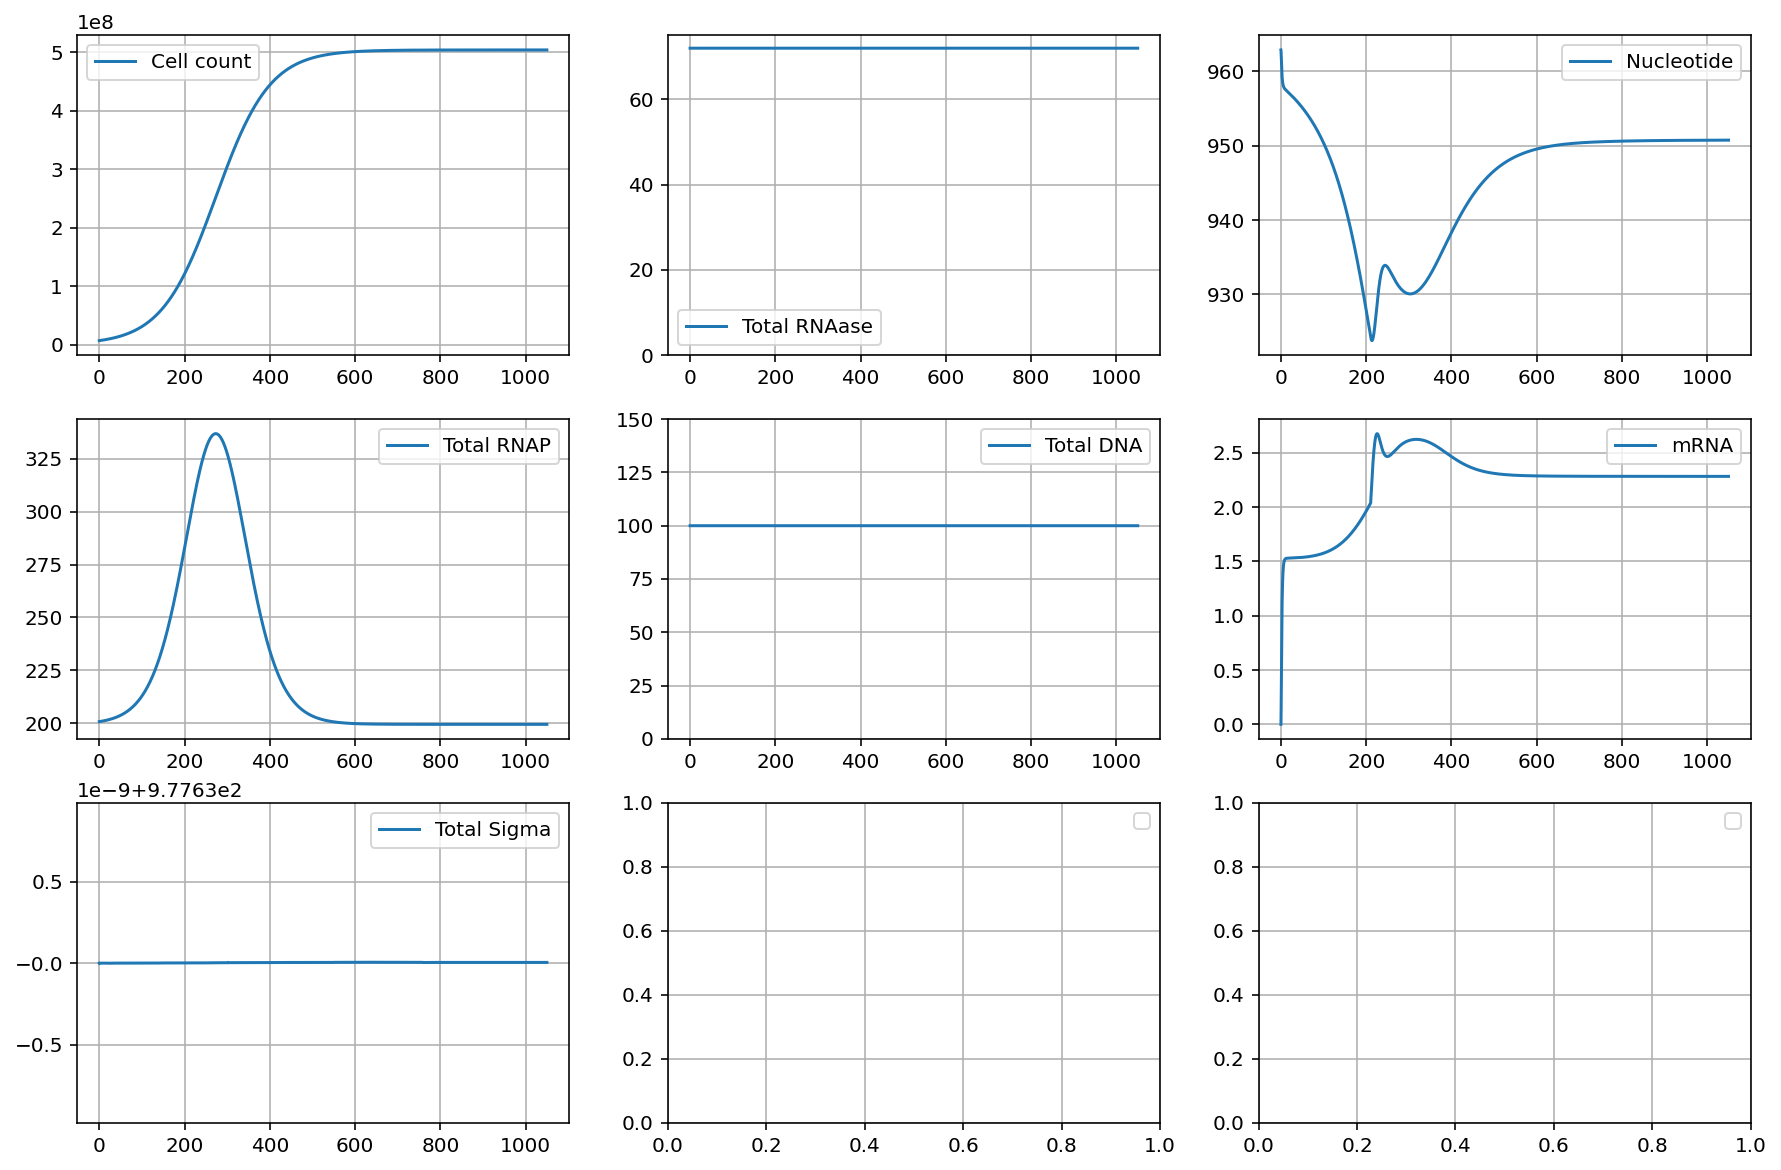

In [18]:
# Total rnap, bound and unbound
RNAP_total = np.zeros(len(timepoints))
RNAP_total[:] = sol_no_deg['protein_RNAP_machinery'][:] + sol_no_deg['complex_protein_RNAP_machinery_protein_sigma_machinery_'][:]  
RNAP_total[:] += sol_no_deg['complex_complex_protein_RNAP_machinery_protein_sigma_machinery__dna_X_open_'][:] 



# Total DNA, bound and unbound
DNA_total = np.zeros(len(timepoints))
DNA_total[:] = sol_no_deg['dna_X'][:] + sol_no_deg['complex_complex_protein_RNAP_machinery_protein_sigma_machinery__dna_X_open_'][:]

# Total sigma, bound and unbound
sigma_total = np.zeros(len(timepoints))
sigma_total[:] = sol_no_deg['protein_sigma_machinery'][:] + sol_no_deg['complex_protein_RNAP_machinery_protein_sigma_machinery_'][:] 
sigma_total[:] += sol_no_deg['complex_complex_protein_RNAP_machinery_protein_sigma_machinery__dna_X_open_'][:] 

# Total RNAase, bound and unbound
rnaase_total = np.zeros(len(timepoints))
rnaase_total[:] = sol_no_deg['protein_RNAase_machinery'][:] + sol_no_deg['complex_protein_RNAase_machinery_rna_T_X_'][:]

fig,ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))
ax[0][0].plot(timepoints, sol_no_deg['cell_count_count'], label = "Cell count")
ax[0][1].plot(timepoints, rnaase_total, label = "Total RNAase");ax[0][1].set_ylim(bottom = 0, top = 75)
ax[0][2].plot(timepoints, sol_no_deg['protein_NT_units'], label = "Nucleotide")
ax[1][0].plot(timepoints, RNAP_total, label = "Total RNAP")
ax[1][1].plot(timepoints, DNA_total, label = "Total DNA");ax[1][1].set_ylim(bottom = 0, top = 150)
ax[1][2].plot(timepoints, sol_no_deg['rna_T_X'], label = "mRNA")
ax[2][0].plot(timepoints, sigma_total, label = "Total Sigma"); #ax[2][0].set_ylim(bottom = 0, top = 1500)


ax[0][0].legend() ; ax[0][0].grid(); 
ax[0][1].legend() ; ax[0][1].grid(); 
ax[0][2].legend() ; ax[0][2].grid(); 
ax[2][0].legend() ; ax[1][0].grid(); 
ax[1][0].legend() ; ax[1][1].grid(); 
ax[1][1].legend() ; ax[1][2].grid(); 
ax[1][2].legend() ; ax[2][0].grid(); 
ax[2][1].legend() ; ax[2][1].grid(); 
ax[2][2].legend() ; ax[2][2].grid(); 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


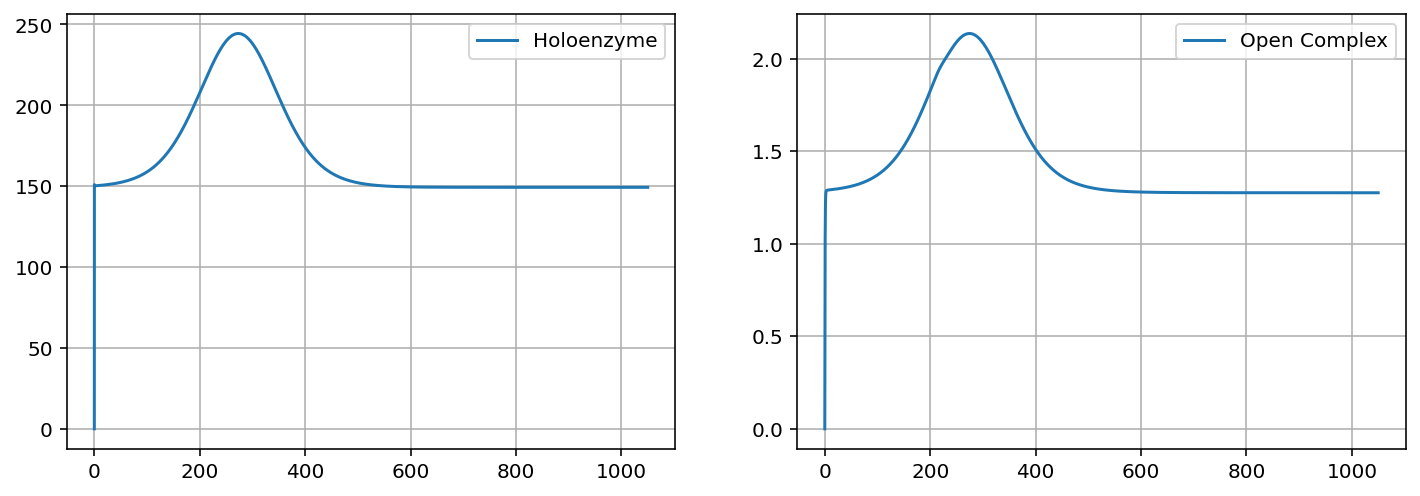

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax[0].plot(timepoints, sol_no_deg['complex_protein_RNAP_machinery_protein_sigma_machinery_'], label = 'Holoenzyme')
ax[1].plot(timepoints, sol_no_deg['complex_complex_protein_RNAP_machinery_protein_sigma_machinery__dna_X_open_'] , label = 'Open Complex')
ax[0].legend(); ax[1].legend(); 
ax[0].grid(); ax[1].grid(); 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


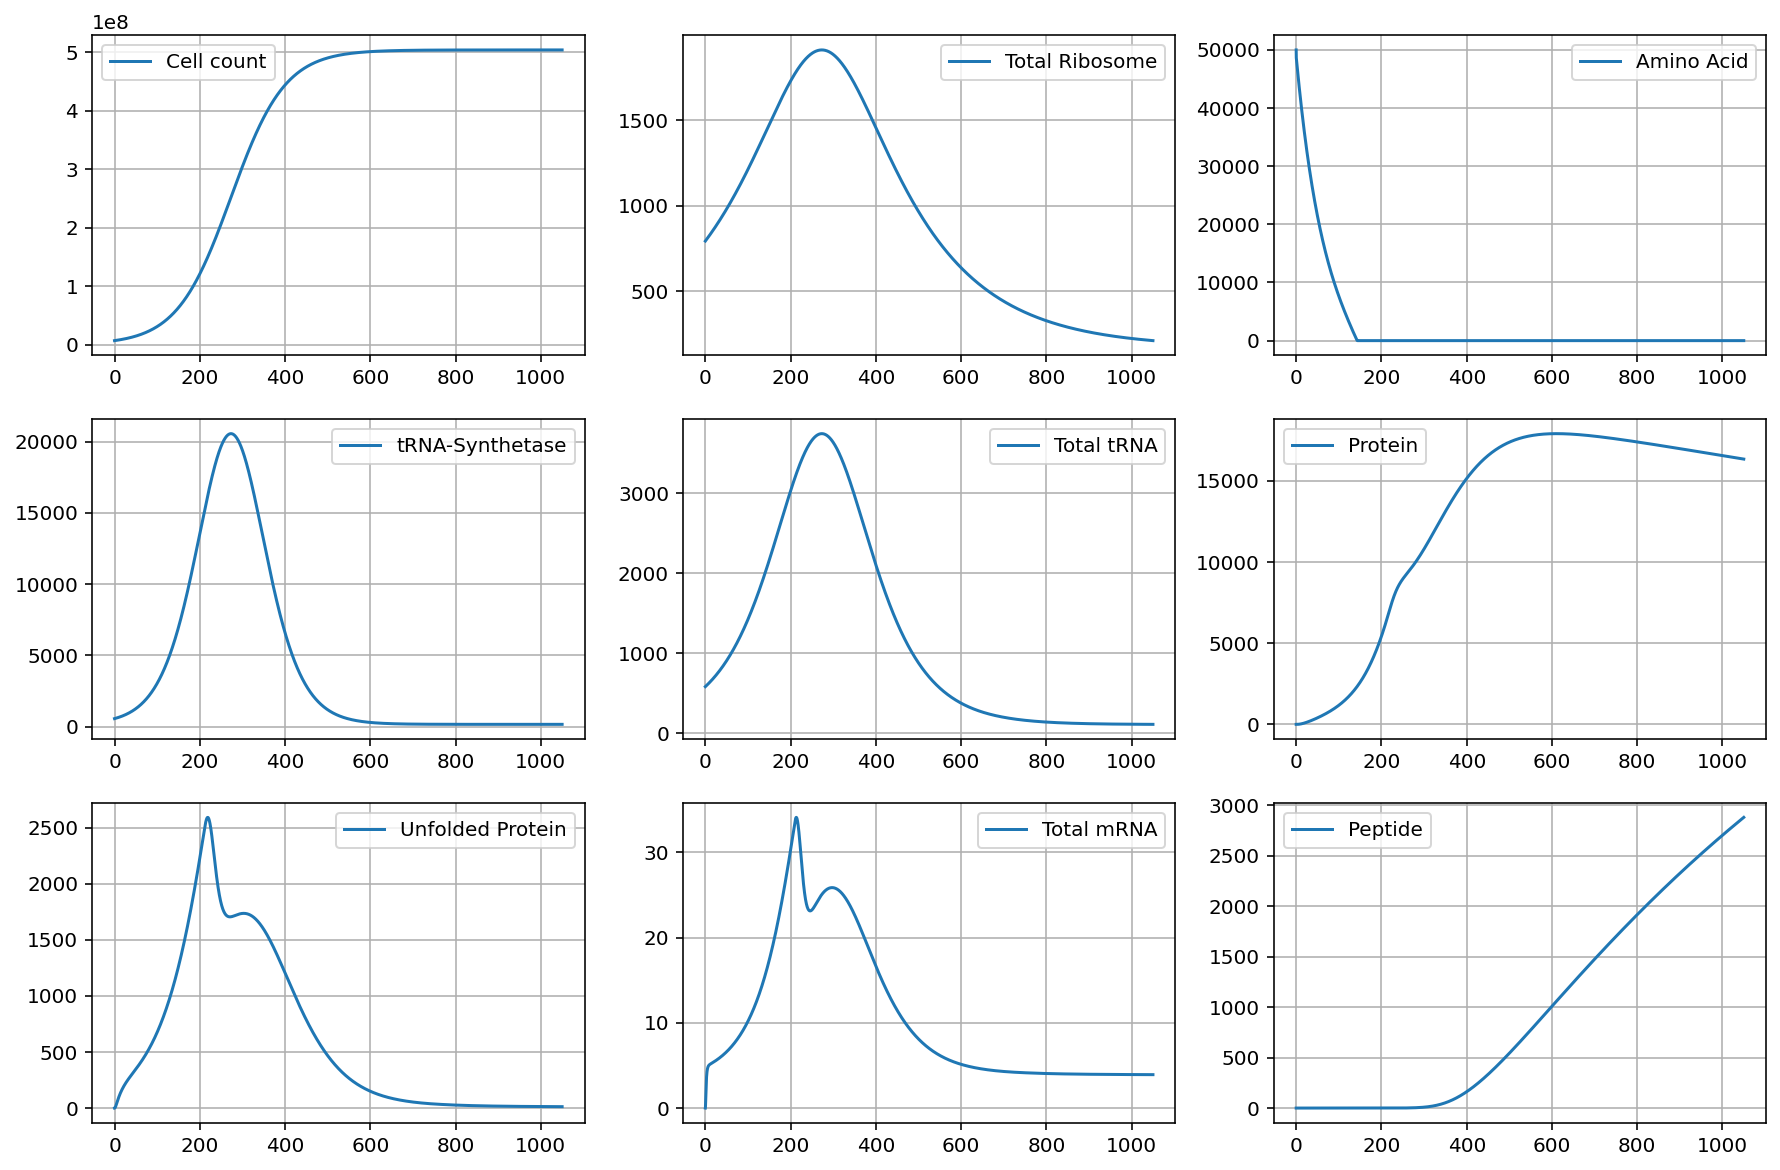

In [20]:
# Total Ribosome, bound and unbound
ribo_total = np.zeros(len(timepoints))
ribo_total[:] = sol_no_deg['protein_Ribo_machinery'][:]
ribo_total[:] += sol_no_deg['complex_complex_protein_AA_units0tl_protein_tRNA_machinery__protein_Ribo_machinery_rna_T_X_'][:]

# Total tRNA, bound and unbound
tRNA_total = np.zeros(len(timepoints))
tRNA_total[:] = sol_no_deg['protein_tRNA_machinery'][:] + sol_no_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_inactive_'][:]
tRNA_total[:] += sol_no_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_active_'][:]
tRNA_total[:] += sol_no_deg['complex_protein_AA_units0tl_protein_tRNA_machinery_'][:]
tRNA_total[:] += sol_no_deg['complex_complex_protein_AA_units0tl_protein_tRNA_machinery__protein_Ribo_machinery_rna_T_X_'][:]

# Total mRNA, bound and unbound
mrna_total = np.zeros(len(timepoints))
mrna_total[:] = sol_no_deg['rna_T_X'][:]
mrna_total[:] += sol_no_deg['complex_complex_protein_AA_units0tl_protein_tRNA_machinery__protein_Ribo_machinery_rna_T_X_'][:]
mrna_total[:] += sol_no_deg['complex_protein_RNAase_machinery_rna_T_X_'][:]


# Total tRNA synthetase
synth_total = np.zeros(len(timepoints))
synth_total[:] = sol_no_deg['protein_Et_machinery'][:]
synth_total[:] += sol_no_deg['complex_protein_AA_units0tl_protein_Et_machinery_'][:]
synth_total[:] += sol_no_deg['complex_protein_AA_units0tl_protein_Et_machinery_amp_'][:]
synth_total[:] += sol_no_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_inactive_'][:]
synth_total[:] += sol_no_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_active_'][:]


# Total Amino Acid 
aa_total = np.zeros(len(timepoints))
aa_total[:] = sol_no_deg['protein_AA_units0tl'][:]
aa_total[:] += sol_no_deg['complex_protein_AA_units0tl_protein_Et_machinery_'][:]
aa_total[:] += sol_no_deg['complex_protein_AA_units0tl_protein_Et_machinery_amp_'][:]
aa_total[:] += sol_no_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_inactive_'][:]
aa_total[:] += sol_no_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_active_'][:]
aa_total[:] += sol_no_deg['complex_protein_AA_units0tl_protein_tRNA_machinery_'][:]
aa_total[:] += sol_no_deg['complex_complex_protein_AA_units0tl_protein_tRNA_machinery__protein_Ribo_machinery_rna_T_X_'][:]

fig,ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))
# ax.set_title("Growth dependent gene expression")

ax[0][0].plot(timepoints, sol_no_deg['cell_count_count'], label = "Cell count")
ax[0][1].plot(timepoints, ribo_total, label = "Total Ribosome")
ax[0][2].plot(timepoints, sol_no_deg['protein_AA_units0tl'] , label = "Amino Acid")
ax[1][0].plot(timepoints, synth_total, label = "tRNA-Synthetase")
ax[1][1].plot(timepoints, tRNA_total, label = "Total tRNA")
ax[1][2].plot(timepoints, sol_no_deg['protein_X'], label = "Protein")
ax[2][0].plot(timepoints, sol_no_deg['protein_unfolded_protein_degtag'], label = "Unfolded Protein")
ax[2][1].plot(timepoints, mrna_total, label = "Total mRNA")
ax[2][2].plot(timepoints, sol_no_deg['protein_peptide_chain_peptide'], label = "Peptide")


ax[0][0].legend() ; ax[0][0].grid(); 
ax[0][1].legend() ; ax[0][1].grid(); 
ax[0][2].legend() ; ax[0][2].grid(); 
ax[2][0].legend() ; ax[1][0].grid(); 
ax[1][0].legend() ; ax[1][1].grid(); 
ax[1][1].legend() ; ax[1][2].grid(); 
ax[1][2].legend() ; ax[2][0].grid(); 
ax[2][1].legend() ; ax[2][1].grid(); 
ax[2][2].legend() ; ax[2][2].grid(); 


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


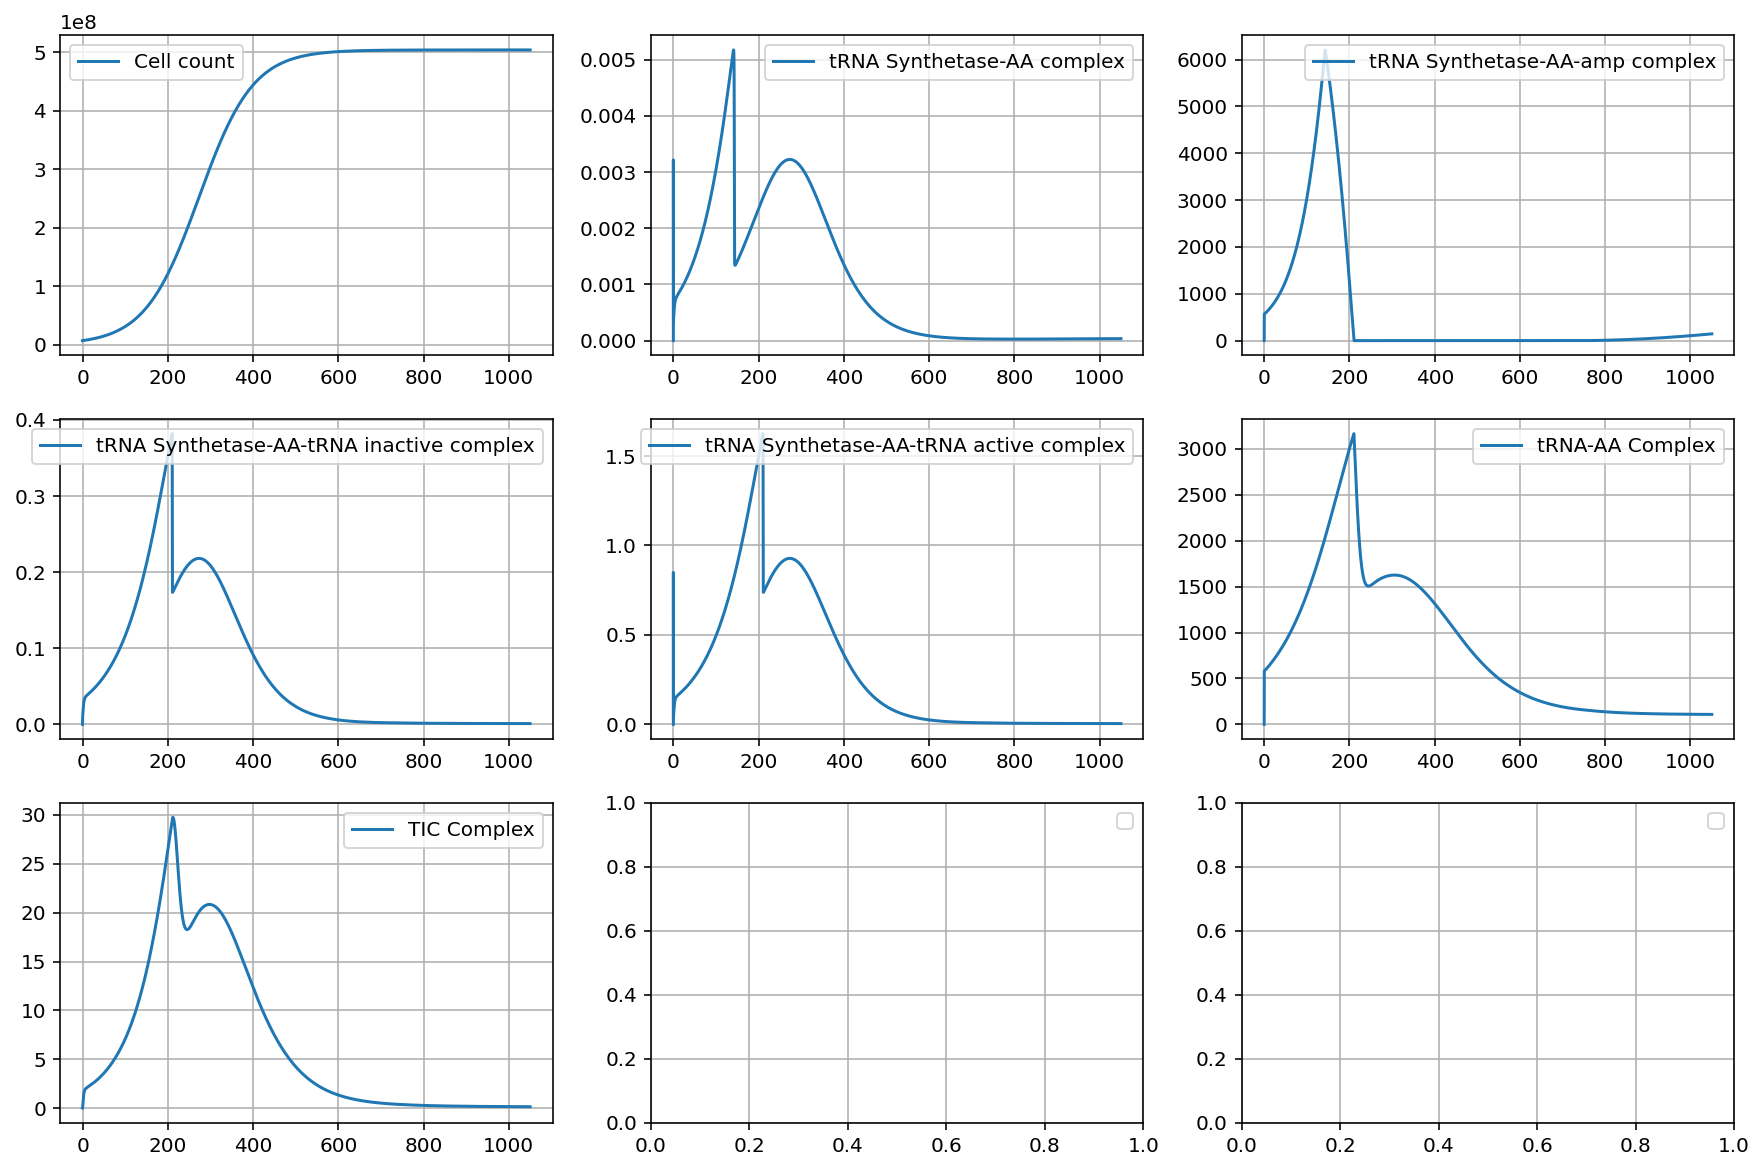

In [21]:
fig,ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))
# ax.set_title("Growth dependent gene expression")

ax[0][0].plot(timepoints, sol_no_deg['cell_count_count'], label = "Cell count")
ax[0][1].plot(timepoints, sol_no_deg['complex_protein_AA_units0tl_protein_Et_machinery_'], label = "tRNA Synthetase-AA complex")
ax[0][2].plot(timepoints, sol_no_deg['complex_protein_AA_units0tl_protein_Et_machinery_amp_'], label = "tRNA Synthetase-AA-amp complex")
ax[1][0].plot(timepoints, sol_no_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_inactive_'],
label = "tRNA Synthetase-AA-tRNA inactive complex")
ax[1][1].plot(timepoints, sol_no_deg['complex_complex_protein_AA_units0tl_protein_Et_machinery_amp__protein_tRNA_machinery_active_'],
label = "tRNA Synthetase-AA-tRNA active complex")
ax[1][2].plot(timepoints, sol_no_deg['complex_protein_AA_units0tl_protein_tRNA_machinery_'], label = "tRNA-AA Complex")
ax[2][0].plot(timepoints,sol_no_deg['complex_complex_protein_AA_units0tl_protein_tRNA_machinery__protein_Ribo_machinery_rna_T_X_'],
label = "TIC Complex")
# ax[2][1].plot(timepoints, R['complex_protein_protease_machinery_protein_unfolded_protein_degtag_'], 
#               label = "Unfolded Protein-Protease Complex")
# ax[2][2].plot(timepoints, R['complex_protein_RNAase_machinery_rna_T_X_'], label = "mRNA-RNAase Complex")



ax[0][0].legend() ; ax[0][0].grid(); 
ax[0][1].legend() ; ax[0][1].grid(); 
ax[0][2].legend() ; ax[0][2].grid(); 
ax[2][0].legend() ; ax[1][0].grid(); 
ax[1][0].legend() ; ax[1][1].grid(); 
ax[1][1].legend() ; ax[1][2].grid(); 
ax[1][2].legend() ; ax[2][0].grid(); 
ax[2][1].legend() ; ax[2][1].grid(); 
ax[2][2].legend() ; ax[2][2].grid(); 
